### The logistic map
Is defined as $x_{i + 1} = \alpha x_{i}(1 - x_{i})$. For $\alpha = 4$ it maps $[0,1]$ onto itself. For $\alpha = 4$ the invariant density is $$ \pi(dx) := \frac{1}{\pi\sqrt{x(1 - x)}}dx,$$
which is a beta distribution with parameters $a = b = 0.5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern

In [2]:
a, b = 0.5, 0.5
def logistic_map(x, r = 4):
    return r * x * (1 - x)

In [23]:
kernel = Matern(nu=0.5, length_scale=0.5)
rank = 20
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 1000
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 100
test_X = beta.rvs(a, b, size = (test_size, test_repetitions))
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,i] = logistic_map(test_X[:,i])

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        X = beta.rvs(a, b, size = train_size)[:, None]
        Y = logistic_map(X)
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,k][:, None], test_Y[:,k][:, None])

KernelRidgeRegression: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


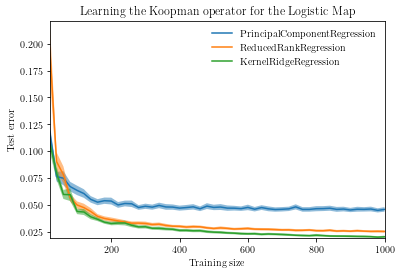

In [25]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for the Logistic Map")
plt.savefig("figs/logistic_map_error.pdf")

In [62]:
kernel = RBF(length_scale = 1.0)
tikhonov_reg = 1e-7
rank = 10
KRR = KernelRidgeRegression(kernel, tikhonov_reg=tikhonov_reg)

estimators = [KRR]#, PCR, RRR]

train_max = 100
train_X = beta.rvs(a, b, size = train_max)[:,None]
train_Y = logistic_map(train_X)

train_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_stops = [int(train_max * i) for i in train_size]

test_size = 10
test_repetitions = 100
test_X = beta.rvs(a, b, size = (test_size, test_repetitions))
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,i] = logistic_map(test_X[:,i])

errors = np.empty((len(estimators), len(train_stops), test_repetitions))
for i, estimator in enumerate(estimators):
    for j, train_stop in tqdm(enumerate(train_stops),desc=f"{estimator.__class__.__name__}", total=len(train_stops)):
        estimator.fit(train_X[:train_stop], train_Y[:train_stop], backend='cpu')
        for k in range(test_repetitions):
            errors[i,j,k] = estimator.risk(test_X[:,k][:, None], test_Y[:,k][:, None])

KernelRidgeRegression: 100%|██████████| 10/10 [00:00<00:00, 52.98it/s]


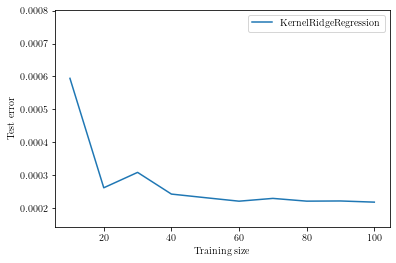

In [63]:
for i, estimator in enumerate(estimators):
    mean = np.mean(errors[i], axis=1)
    std = np.std(errors[i], axis=1)
    plt.fill_between(test_size, mean - std, mean + std, alpha=0.2)
    plt.plot(train_stops, mean, label=estimator.__class__.__name__)
    plt.xlabel("Training size")
    plt.ylabel("Test error")
    plt.legend()

In [58]:
KRR.fit(train_X, train_Y, backend='cpu')

/tmp/ipykernel_258273/1205511032.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(np.linalg.eigvalsh(KRR.K_X)), 'k.')


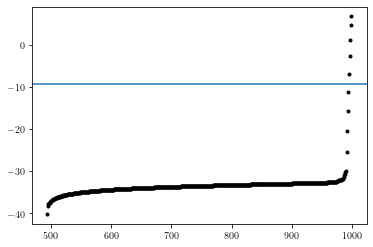

In [59]:
plt.plot(np.log(np.linalg.eigvalsh(KRR.K_X)), 'k.')
plt.axhline(np.log(tikhonov_reg*train_max))

In [36]:
np.linalg.eigvalsh(KRR.K_X)

array([-5.37133741e-13, -3.83054607e-13, -2.64564764e-13, ...,
        6.75882210e+00,  2.10164386e+02,  1.78293035e+03])